To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth your local device, follow [our guide](https://docs.unsloth.ai/get-started/install-and-update). This notebook is licensed [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News


Unsloth's [Docker image](https://hub.docker.com/r/unsloth/unsloth) is here! Start training with no setup & environment issues. [Read our Guide](https://docs.unsloth.ai/new/how-to-train-llms-with-unsloth-and-docker).

[gpt-oss RL](https://docs.unsloth.ai/new/gpt-oss-reinforcement-learning) is now supported with the fastest inference & lowest VRAM. Try our [new notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/gpt-oss-(20B)-GRPO.ipynb) which creates kernels!

Introducing [Vision](https://docs.unsloth.ai/new/vision-reinforcement-learning-vlm-rl) and [Standby](https://docs.unsloth.ai/basics/memory-efficient-rl) for RL! Train Qwen, Gemma etc. VLMs with GSPO - even faster with less VRAM.

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [2]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

### Unsloth

In [4]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.11.2: Fast Mllama patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 2777 has 14.73 GiB memory in use. Of the allocated memory 14.56 GiB is allocated by PyTorch, and 31.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.vision_model.transformer` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.


In [4]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="qa_corpus.json", split="train")

README.md:   0%|          | 0.00/610 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1978 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/327 [00:00<?, ? examples/s]

Let's take a look at the dataset, and check what the 1st example shows:

In [1]:
dataset

NameError: name 'dataset' is not defined

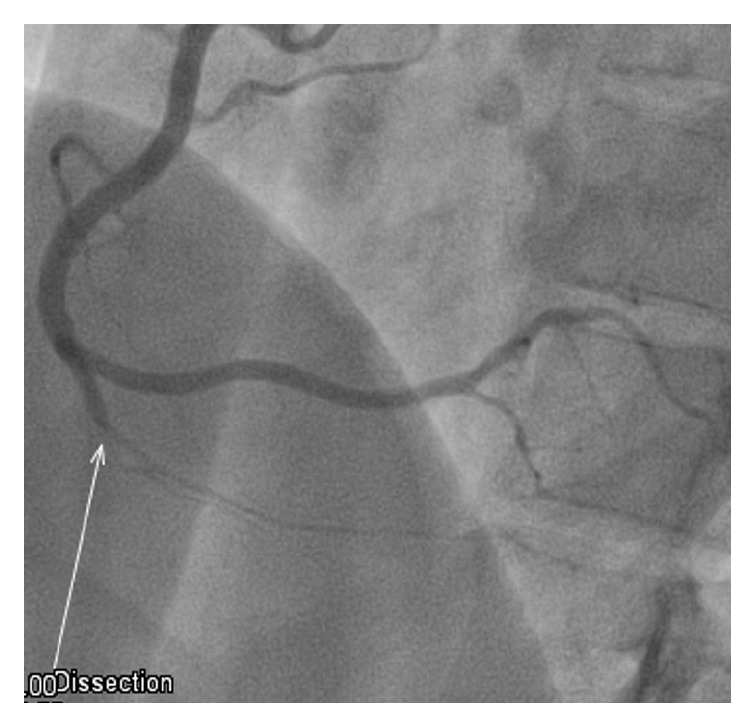

In [6]:
dataset[8]["image"]

In [8]:
dataset[3]["caption"]

'Pericarditis.'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [10]:
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [11]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [12]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiographer. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=657x442>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Panoramic radiography shows an osteolytic lesion in the right posterior maxilla with resorption of the floor of the maxillary sinus (arrows).'}]}]}

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [13]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This radiograph appears to be a Panoramic Radiograph, also known as a Pano, of a patient's maxillofacial anatomy.

It shows the left zygomatic bone's relationship to surrounding structures. This patient had suffered a fracture at the same time that the teeth were lost. The fracture appears to be stable, with some misalignment of the lower right lateral incisors. In this case, the radiograph appears to show an older patient whose facial growth may have been complete at the time of injury, based on the overall bony structure. Therefore, any misalignment can be easily managed.  Overall, it appears


<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [14]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

In [15]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
8.584 GB of memory reserved.


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,978 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400 of 10,737,395,235 (0.63% trained)


Step,Training Loss
1,3.545600
2,3.555200
3,3.199400
4,2.859200
5,2.590900
6,2.508200
7,2.126100
8,1.880200
9,1.630600
10,1.341900


Unsloth: Will smartly offload gradients to save VRAM!


In [17]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

707.0402 seconds used for training.
11.78 minutes used for training.
Peak reserved memory = 10.084 GB.
Peak reserved memory for training = 1.5 GB.
Peak reserved memory % of max memory = 68.408 %.
Peak reserved memory for training % of max memory = 10.176 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [18]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",  # test
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiography shows multiple small osteolytic lesions, indicated by arrows, in the left maxilla, which is the main area of involvement.<|eot_id|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [19]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [20]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This panoramic X-ray demonstrates an extensive bony radiographic lesion affecting the right maxillary and zygomatic areas.<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [21]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️

  This notebook and all Unsloth notebooks are licensed [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme)
</div>
